In [343]:
!pip install psycopg2 requests pandas numpy scikit-learn matplotlib joblib 

In [314]:
# Check if Docker Desktop is installed
import subprocess
docker_desktop_path = "C:\\Program Files\\Docker\\Docker\\resources\\bin\\docker.exe"
result = subprocess.run([docker_desktop_path, "--version"], capture_output=True, text=True)
print(result.stdout)

Docker version 27.1.1, build 6312585



In [315]:
#Setup DB docker container
result = subprocess.run([docker_desktop_path, "pull", "postgres:latest"], capture_output=True, text=True)
print(result.stdout)

print("setting up db")
result2 = subprocess.run([docker_desktop_path, "run", "-d", "--name", "my_postgres", 
                          "-e", "POSTGRES_USER=myuser", "-e", "POSTGRES_PASSWORD=mypassword", 
                          "-e", "POSTGRES_DB=mydatabase", "-v", "pgdata:/var/lib/postgresql/data", 
                          "-p", "5432:5432", "postgres:latest"], capture_output=True, text=True)
print(result2.stdout)

print("check docker running containers")
result3 = subprocess.run([docker_desktop_path, "ps"], capture_output=True, text=True)
print(result3.stdout)


latest: Pulling from library/postgres
Digest: sha256:026d0ab72b34310b68160ab9299aa1add5544e4dc3243456b94f83cb1c119c2c
Status: Image is up to date for postgres:latest
docker.io/library/postgres:latest

setting up db

check docker running containers
CONTAINER ID   IMAGE             COMMAND                  CREATED        STATUS        PORTS                    NAMES
c3137f1d9797   postgres:latest   "docker-entrypoint.s…"   28 hours ago   Up 19 hours   0.0.0.0:5432->5432/tcp   my_postgres



Download the JSON file from the website
Comment after downloaded to prevent re-download attempt after token expired

In [316]:
'''import requests

url = ["https://www.ura.gov.sg/uraDataService/invokeUraDS?service=PMI_Resi_Transaction&batch=1",
       "https://www.ura.gov.sg/uraDataService/invokeUraDS?service=PMI_Resi_Transaction&batch=2",
       "https://www.ura.gov.sg/uraDataService/invokeUraDS?service=PMI_Resi_Transaction&batch=3",
       "https://www.ura.gov.sg/uraDataService/invokeUraDS?service=PMI_Resi_Transaction&batch=4"]

# Headers as specified in the curl command
headers = {
    "AccessKey": "a716aeab-c83e-4897-94bc-2bb469bc00f5",
    "Token": "y7-gak4Aea3599RE8HQvb5qcm4464@93rpb7H+xy6fn0b-4-XdZ997Z55e98ta2wjb@yRcaSTd8n8pT3bkq4wf---34M07cc059b",
    "User-Agent": "curl/8.7.1",
    "Accept": "*/*",
}

# Make the GET request
for i, u in enumerate(url):
    print(f"Attemping {u}")
    response = requests.get(u, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        # Save the response to a file
        with open(f"transaction_downloads{i+1}.json", "w") as f:
            f.write(response.text)
        print(f"Data successfully downloaded and saved for batch {i+1}.")
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}, Error: {response.text}")'''

'import requests\n\nurl = ["https://www.ura.gov.sg/uraDataService/invokeUraDS?service=PMI_Resi_Transaction&batch=1",\n       "https://www.ura.gov.sg/uraDataService/invokeUraDS?service=PMI_Resi_Transaction&batch=2",\n       "https://www.ura.gov.sg/uraDataService/invokeUraDS?service=PMI_Resi_Transaction&batch=3",\n       "https://www.ura.gov.sg/uraDataService/invokeUraDS?service=PMI_Resi_Transaction&batch=4"]\n\n# Headers as specified in the curl command\nheaders = {\n    "AccessKey": "a716aeab-c83e-4897-94bc-2bb469bc00f5",\n    "Token": "y7-gak4Aea3599RE8HQvb5qcm4464@93rpb7H+xy6fn0b-4-XdZ997Z55e98ta2wjb@yRcaSTd8n8pT3bkq4wf---34M07cc059b",\n    "User-Agent": "curl/8.7.1",\n    "Accept": "*/*",\n}\n\n# Make the GET request\nfor i, u in enumerate(url):\n    print(f"Attemping {u}")\n    response = requests.get(u, headers=headers)\n\n    # Check if the request was successful\n    if response.status_code == 200:\n        # Save the response to a file\n        with open(f"transaction_downloads

In [317]:
# Imports
import json
import psycopg2


Create a connection session

In [318]:
# Load JSON data from the file
with open('transaction_downloads3.json', 'r') as f:
    data = json.load(f)

# Connect to PostgreSQL
conn = psycopg2.connect(
    host="localhost",
    database="mydatabase",
    user="myuser",
    password="mypassword"
)
cur = conn.cursor()

In [319]:
table_ver = 3
sql_create_table_query = f"""CREATE TABLE transactions_v{table_ver} (
    transaction_id SERIAL PRIMARY KEY,
    project VARCHAR(100),
    market_segment VARCHAR(10),
    contract_date CHAR(4),  -- Store MMYY format
    commence_date CHAR(4),  -- Store MMYY format
    months_since_contract_date INTEGER,  
    months_since_commence_date INTEGER,  
    area INTEGER,
    price NUMERIC(10, 2),
    property_type VARCHAR(50),
    type_of_area VARCHAR(50),
    tenure VARCHAR(100),
    floor_range VARCHAR(10),
    type_of_sale INTEGER,
    district VARCHAR(10),
    no_of_units INTEGER,
    street VARCHAR(100),
    x_coordinate NUMERIC(12, 8),
    y_coordinate NUMERIC(12, 8)
);
"""
sql_check_table_name_query ="""SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'public';
"""
sql_check_field_name_query=f"""SELECT column_name, data_type, character_maximum_length
FROM information_schema.columns
WHERE table_name = 'transactions_v{table_ver}';
"""

Generate table

In [320]:
# Check if table exists
check_table_query = f"""
SELECT EXISTS (
    SELECT FROM information_schema.tables 
    WHERE table_schema = 'public'
    AND table_name = 'transactions_v{table_ver}'
);
"""
cur.execute(check_table_query)
table_exists = cur.fetchone()[0]

if not table_exists:
    # Table doesn't exist, so create it
    cur.execute(sql_create_table_query)
    conn.commit()
    print(f"Table 'transactions_v{table_ver}' created successfully.")
else:
    print(f"Table 'transactions_v{table_ver}' already exists.")

# ... existing code ...


Table 'transactions_v3' already exists.


Check out the tables and table fields

In [321]:
cur.execute(sql_check_table_name_query)

table_names = cur.fetchall()
print("Tables in the database:")
for table in table_names:
    print(table[0])
    
# Execute the query for the 'transactions' table
cur.execute(sql_check_field_name_query)

# Fetch all results
field_info = cur.fetchall()

# Print the results
print(f"\nFields in the 'transactions v{table_ver}' table:")
for field in field_info:
    print(f"Column: {field[0]}, Type: {field[1]}, Max Length: {field[2]}")

Tables in the database:
transactions
json_staging
transactions_v3

Fields in the 'transactions v3' table:
Column: transaction_id, Type: integer, Max Length: None
Column: months_since_contract_date, Type: integer, Max Length: None
Column: months_since_commence_date, Type: integer, Max Length: None
Column: area, Type: integer, Max Length: None
Column: price, Type: integer, Max Length: None
Column: type_of_sale, Type: integer, Max Length: None
Column: no_of_units, Type: integer, Max Length: None
Column: x_coordinate, Type: numeric, Max Length: None
Column: y_coordinate, Type: numeric, Max Length: None
Column: property_type, Type: character varying, Max Length: 50
Column: type_of_area, Type: character varying, Max Length: 50
Column: project, Type: character varying, Max Length: 100
Column: market_segment, Type: character varying, Max Length: 10
Column: contract_date, Type: character, Max Length: 4
Column: commence_date, Type: character, Max Length: 4
Column: tenure, Type: character varying

Quick exploration of the data. Look through first 10 items


In [322]:
for i, item in enumerate(data['Result']):
    print(item)
    if i > 10:
        break
print(f"Fields: {item.keys()} total items {len(item.keys())}")
print(f"Transaction fields {item['transaction'][0].keys()} total items {len(item['transaction'][0].keys())}")


{'street': 'ELLIOT ROAD', 'x': '38874.48712', 'project': 'ELLIOT AT THE EAST COAST', 'y': '32613.09564', 'transaction': [{'area': '92', 'floorRange': '01-05', 'noOfUnits': '1', 'contractDate': '0919', 'typeOfSale': '3', 'price': '1650000', 'propertyType': 'Condominium', 'district': '15', 'typeOfArea': 'Strata', 'tenure': 'Freehold'}, {'area': '126', 'floorRange': '01-05', 'noOfUnits': '1', 'contractDate': '0820', 'typeOfSale': '3', 'price': '1875000', 'propertyType': 'Condominium', 'district': '15', 'typeOfArea': 'Strata', 'tenure': 'Freehold'}, {'area': '236', 'floorRange': '01-05', 'noOfUnits': '1', 'contractDate': '0820', 'typeOfSale': '3', 'price': '2700000', 'propertyType': 'Condominium', 'district': '15', 'typeOfArea': 'Strata', 'tenure': 'Freehold'}, {'area': '47', 'floorRange': '01-05', 'noOfUnits': '1', 'contractDate': '1219', 'typeOfSale': '3', 'price': '810000', 'propertyType': 'Condominium', 'district': '15', 'typeOfArea': 'Strata', 'tenure': 'Freehold'}, {'area': '91', 'fl

function used to convert mmyy to months_from then to now

In [323]:
def convert_mmyy_then2now(mmyy:str)-> int:
    mm, yy = int(mmyy[0:2]), int(mmyy[2:])
    then2now_monnths = (24 - yy) * 12 + (9 - mm)
    return then2now_monnths

    

Begin populating in each transaction as one row in the transaction table

In [324]:
transaction_id = 0
# Modify the table schema if necessary
alter_table_query = f"""
ALTER TABLE transactions_v{table_ver}
ALTER COLUMN x_coordinate TYPE NUMERIC(11, 4),
ALTER COLUMN y_coordinate TYPE NUMERIC(11, 4),
ALTER COLUMN price TYPE INTEGER;
"""
conn.rollback()
cur.execute(alter_table_query)
conn.commit()

# Delete all old rows from the table
delete_query = f"DELETE FROM transactions_v{table_ver};"
cur.execute(delete_query)
conn.commit()
print(f"All rows deleted from transactions_v{table_ver}")

t_item_required_keys = ['contractDate', 'tenure', 'area', 'price', 'typeOfSale', 'noOfUnits', 'propertyType', 'typeOfArea', 'district', 'floorRange']
item_required_keys = ['street', 'project', 'marketSegment']


for i, item in enumerate(data['Result']):
    if not all(key in item.keys() for key in item_required_keys):
        print(f"skipping item not complete  {item.keys()}")
        continue
    for x, transaction_item in enumerate(item['transaction']):
        if not all(key in transaction_item.keys() for key in t_item_required_keys):
            print(f"skipping t item not complete {transaction_item.keys()}")
            continue
        
        # Filter away non lease base condo
        if transaction_item['tenure'] == "Freehold":
            continue
        # some rows has no commencing from year, filter them out
        if "commencing from" not in transaction_item['tenure']:
            continue
        # lease before singapore founding are irrelevant
        if int(transaction_item['tenure'][-4:]) < 1965:
            continue

        # We only want to look at ECs to predict resale price at 5th year mark since commencement
        if transaction_item['propertyType'] != "Executive Condominium":
            continue
        # Filter away contract date not within specified point 
        # where contract date is not 5 years from lease commencement
        months_since_contract_date = convert_mmyy_then2now(transaction_item['contractDate'])
        months_since_commence_date = convert_mmyy_then2now("01" + transaction_item['tenure'][-2:])
        if months_since_commence_date - months_since_contract_date < 60:
            continue
        if months_since_commence_date - months_since_contract_date > 90:
            continue
            
        
        # Filter away contract dates older than 5 years ago
        if months_since_contract_date > 60:
            continue
        
        
        area = int(round(float(transaction_item['area'])))
        price = int(transaction_item['price'])
        type_of_sale = transaction_item['typeOfSale']
        no_of_units = transaction_item['noOfUnits']
        x_coordinate = item['x'] if 'x' in item.keys() else 0
        y_coordinate = item['y'] if 'y' in item.keys() else 0
        property_type = transaction_item['propertyType']
        type_of_area = transaction_item['typeOfArea']
        project = item['project']
        market_segment = item['marketSegment']
        contract_date = transaction_item['contractDate']
        commence_date = "06" + transaction_item['tenure'][-2:]
        tenure = transaction_item['tenure']
        floor_range = transaction_item['floorRange']
        street = item['street']
        district = transaction_item['district']
        transaction_tuple = (transaction_id, months_since_contract_date, months_since_commence_date, 
                             area, price, type_of_sale, no_of_units, x_coordinate, y_coordinate, property_type, 
                             type_of_area, project, market_segment, contract_date, commence_date, tenure, 
                             floor_range, street, district)
        # Insert data into the table
        cur.execute(
            f"""
            INSERT INTO transactions_v{table_ver} (transaction_id, months_since_contract_date, months_since_commence_date, 
            area, price, type_of_sale, no_of_units, x_coordinate, y_coordinate, property_type, 
            type_of_area, project, market_segment, contract_date, commence_date, tenure, 
            floor_range, street, district) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
            """,
            transaction_tuple
        )
        transaction_id += 1


print(f"FINAL TRANSACTION _ID {transaction_id}")
print(f"Fields: {item.keys()} total items {len(item.keys())}")
print(f"Transaction fields {item['transaction'][0].keys()} total items {len(item['transaction'][0].keys())}")
conn.commit()


All rows deleted from transactions_v3
FINAL TRANSACTION _ID 21
Fields: dict_keys(['street', 'x', 'project', 'y', 'transaction', 'marketSegment']) total items 6
Transaction fields dict_keys(['area', 'floorRange', 'noOfUnits', 'contractDate', 'typeOfSale', 'price', 'propertyType', 'district', 'typeOfArea', 'tenure']) total items 10


In [325]:
# Count rows in the table
count_query = f"SELECT COUNT(*) FROM transactions_v{table_ver};"
cur.execute(count_query)
row_count = cur.fetchone()[0]

print(f"Number of rows in transactions_v{table_ver}: {row_count}")

Number of rows in transactions_v3: 21


Generate random 50 sample rows to inspect (Do run this multiple times)

In [326]:
# Generate 50 random sample rows
sample_query = f"""
SELECT *
FROM transactions_v{table_ver}
ORDER BY RANDOM()
LIMIT 50;
"""

cur.execute(sample_query)
sample_rows = cur.fetchall()

# Print the sample rows
print(f"Sample of 50 rows from transactions_v{table_ver}:")
for row in sample_rows:
    print(row)

# Optionally, you can also print the column names
column_names = [desc[0] for desc in cur.description]
print("\nColumn names:")
print(column_names)

Sample of 50 rows from transactions_v3:
(5, 'THE VALES', 'OCR', '0521', '0614', 40, 128, 84, 920000, 'Executive Condominium', 'Strata', '99 yrs lease commencing from 2014', '01-05', 3, '19', 1, 'ANCHORVALE CRESCENT', Decimal('34777.8877'), Decimal('42111.5820'))
(14, 'RIVERCOVE RESIDENCES', 'OCR', '0221', '0616', 43, 104, 84, 1049000, 'Executive Condominium', 'Strata', '99 yrs lease commencing from 2016', '06-10', 1, '19', 1, 'ANCHORVALE LANE', Decimal('33600.4728'), Decimal('41713.5921'))
(9, 'SEA HORIZON', 'OCR', '0520', '0613', 52, 140, 124, 1250000, 'Executive Condominium', 'Strata', '99 yrs lease commencing from 2013', '06-10', 3, '18', 1, 'PASIR RIS RISE', Decimal('41961.3081'), Decimal('39816.5910'))
(6, 'THE TERRACE', 'OCR', '0220', '0613', 55, 140, 93, 885000, 'Executive Condominium', 'Strata', '99 yrs lease commencing from 2013', '01-05', 3, '19', 1, 'EDGEDALE PLAINS', Decimal('37305.2104'), Decimal('42572.7257'))
(10, 'HUNDRED PALMS RESIDENCES', 'OCR', '1222', '0616', 21, 10

In [327]:
# Generate 5 detailed random sample rows
sample_query = f"""
SELECT *
FROM transactions_v{table_ver}
ORDER BY RANDOM()
LIMIT 5;
"""

cur.execute(sample_query)
sample_rows = cur.fetchall()

# Get column names
column_names = [desc[0] for desc in cur.description]

# Print the sample rows with field names
print(f"Sample of up to 5 rows from transactions_v{table_ver}:")
for row in sample_rows:
    print("\n--- New Row ---")
    for field_name, value in zip(column_names, row):
        print(f"{field_name}: {value}")

# Print summary
print(f"\nTotal sample rows: {len(sample_rows)}")
print(f"Fields: {', '.join(column_names)}")

Sample of up to 5 rows from transactions_v3:

--- New Row ---
transaction_id: 0
project: TREASURE CREST
market_segment: OCR
contract_date: 1221
commence_date: 0615
months_since_contract_date: 33
months_since_commence_date: 116
area: 107
price: 1238880
property_type: Executive Condominium
type_of_area: Strata
tenure: 99 yrs lease commencing from 2015
floor_range: 01-05
type_of_sale: 3
district: 19
no_of_units: 1
street: ANCHORVALE CRESCENT
x_coordinate: 34616.2892
y_coordinate: 42216.2319

--- New Row ---
transaction_id: 17
project: RIVERCOVE RESIDENCES
market_segment: OCR
contract_date: 0321
commence_date: 0616
months_since_contract_date: 42
months_since_commence_date: 104
area: 110
price: 1413000
property_type: Executive Condominium
type_of_area: Strata
tenure: 99 yrs lease commencing from 2016
floor_range: 11-15
type_of_sale: 1
district: 19
no_of_units: 1
street: ANCHORVALE LANE
x_coordinate: 33600.4728
y_coordinate: 41713.5921

--- New Row ---
transaction_id: 18
project: RIVERCOVE R

Test train a simple ML Model to ensure data processing pipeline is right.  
Also evaluate the importance of each feature quickly using RandomForestRegressor

Price - Mean: 1241470.48, Std: 209198.69


C:\Users\guang\AppData\Local\Temp\ipykernel_67428\3211474891.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Root Mean Squared Error (Unnormalized): 171123.40582164674
R-squared Score: -2.36524034126669

Feature Importance:
                      feature  importance
1  months_since_contract_date    0.479290
2  months_since_commence_date    0.246711
3                        area    0.223014
4                 floor_range    0.050986
0              market_segment    0.000000


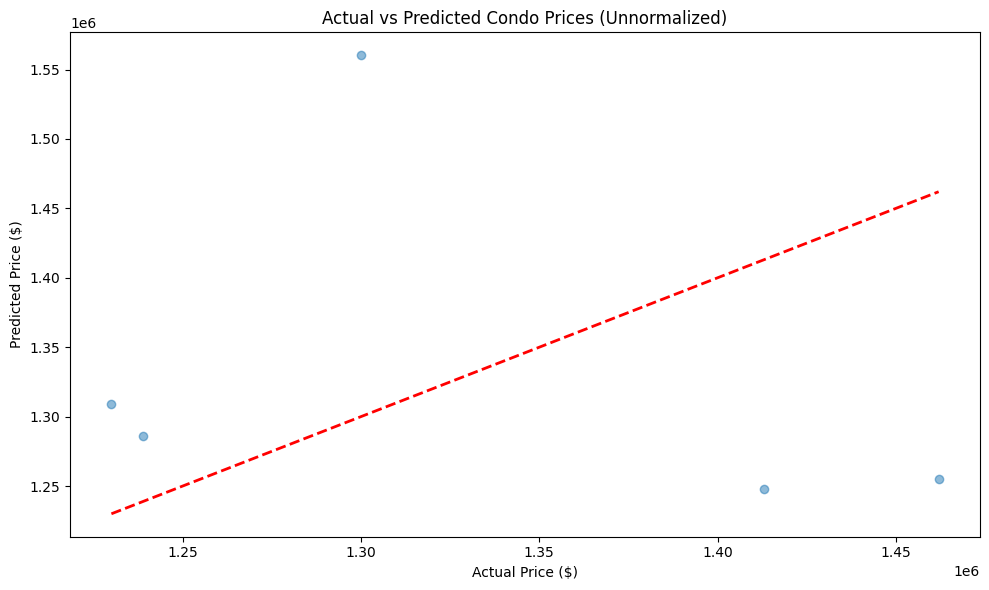

'joblib.dump(rf_model, \'condo_price_predictor.joblib\')\njoblib.dump(le_market_segment, \'le_market_segment.joblib\')\njoblib.dump(le_floor_range, \'le_floor_range.joblib\')\njoblib.dump((price_mean, price_std), \'normalization_params.joblib\')  # Save mean and std\nprint("Model and encoders saved")\n\n'

In [328]:
'''import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

# 1. Fetch data from the database
query = f"""
SELECT market_segment, months_since_contract_date, months_since_commence_date, 
       area, price, floor_range
FROM transactions_v{table_ver}
"""
df = pd.read_sql_query(query, conn)

# 2. Preprocess the data
# Create separate LabelEncoders for each categorical variable
le_market_segment = LabelEncoder()
le_floor_range = LabelEncoder()

# Fit and transform each categorical column
df['market_segment'] = le_market_segment.fit_transform(df['market_segment'])
df['floor_range'] = le_floor_range.fit_transform(df['floor_range'])

# Engineer new feature
# df['age_of_property_at_transaction_date'] = df['months_since_commence_date'] - df['months_since_contract_date']


# 2. Preprocess the data
# Calculate mean and std for 'price'
price_mean, price_std = df['price'].mean(), df['price'].std()
print(f"Price - Mean: {price_mean:.2f}, Std: {price_std:.2f}")

# Normalize 'price'
df['price_normalized'] = (df['price'] - price_mean) / price_std

# Split features and target
X = df.drop(['price', 'price_normalized'], axis=1)
y = df['price_normalized']

# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 5. Make predictions
y_pred_normalized = rf_model.predict(X_test)

# Denormalize predictions and actual values
y_pred = y_pred_normalized * price_std + price_mean
y_test_denormalized = y_test * price_std + price_mean

# 6. Evaluate the model
mse = mean_squared_error(y_test_denormalized, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_denormalized, y_pred)


print(f"Root Mean Squared Error (Unnormalized): {rmse}")
print(f"R-squared Score: {r2}")

# 7. Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# 8. Visualize predictions vs actual (Unnormalized)
plt.figure(figsize=(10, 6))
plt.scatter(y_test_denormalized, y_pred, alpha=0.5)
plt.plot([y_test_denormalized.min(), y_test_denormalized.max()], 
         [y_test_denormalized.min(), y_test_denormalized.max()], 'r--', lw=2)
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Actual vs Predicted Condo Prices (Unnormalized)")
plt.tight_layout()
plt.show()
'''
# 9. This is just a test train to verify processing pipeline is right.
# Dont save this as it is not optimal, proceed to fine-tune it in the next cell
'''joblib.dump(rf_model, 'condo_price_predictor.joblib')
joblib.dump(le_market_segment, 'le_market_segment.joblib')
joblib.dump(le_floor_range, 'le_floor_range.joblib')
joblib.dump((price_mean, price_std), 'normalization_params.joblib')  # Save mean and std
print("Model and encoders saved")

'''



In [329]:
df

,market_segment,months_since_contract_date,months_since_commence_date,area,price,floor_range,price_normalized
0,0,33,116,107,1238880,0,-0.012383
1,0,32,116,100,1230000,2,-0.054831
2,0,26,116,107,1330000,2,0.423184
3,0,53,128,97,960000,1,-1.345470
4,0,46,128,97,1020000,1,-1.058661
5,0,40,128,84,920000,0,-1.536675
6,0,55,140,93,885000,0,-1.703980
7,0,15,80,124,1803000,0,2.684192
8,0,2,80,78,1300000,3,0.279780
9,0,52,140,124,1250000,1,0.040772


Define list of models, automate fine-tunning by GridSearch

Price - Mean: 1241470.48, Std: 209198.69
Best model: {'regressor': ElasticNet(), 'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.1}
Root Mean Squared Error (Unnormalized): $123413.99
R-squared Score: -0.7504


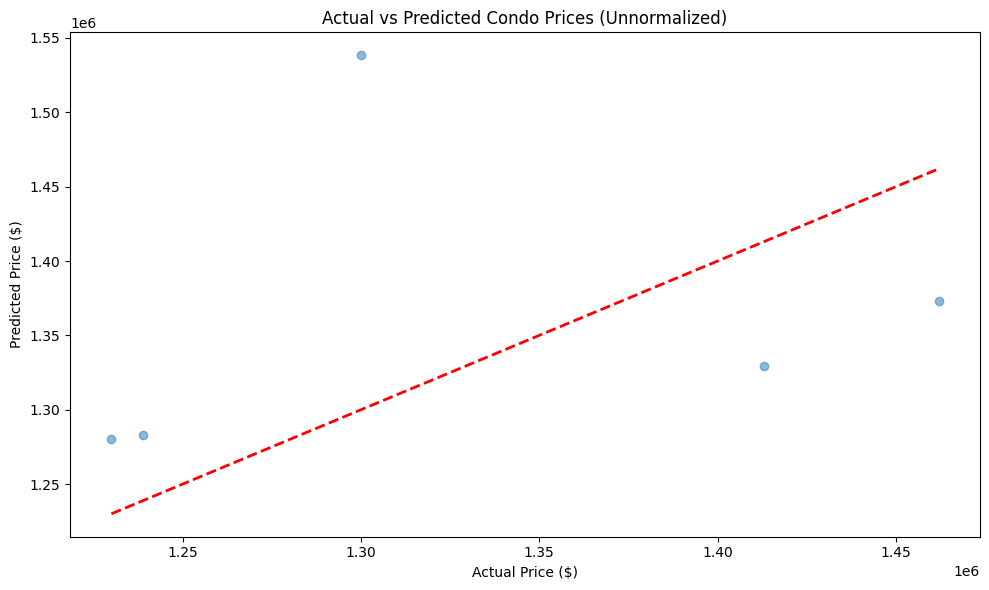

Best model and normalization parameters saved


In [339]:
'''import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import joblib

# ... (keep your data loading and preprocessing steps the same)

# Calculate mean and std for 'price'
price_mean, price_std = df['price'].mean(), df['price'].std()

print(f"Price - Mean: {price_mean:.2f}, Std: {price_std:.2f}")

# Normalize 'price'
df['price_normalized'] = (df['price'] - price_mean) / price_std

# Split features and target
X = df.drop(['price', 'price_normalized'], axis=1)
y = df['price_normalized']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())
])

# Define the models and their hyperparameters to search
param_grid = [
    {
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20, 30],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    },
    {
        'regressor': [ElasticNet()],
        'regressor__alpha': [0.1, 1.0, 10.0],
        'regressor__l1_ratio': [0.1, 0.5, 0.9]
    },
    {
        'regressor': [SVR()],
        'regressor__C': [0.1, 1.0, 10.0],
        'regressor__kernel': ['rbf', 'linear']
    }
]

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred_normalized = best_model.predict(X_test)

# Denormalize predictions and actual values
y_pred = y_pred_normalized * price_std + price_mean
y_test_denormalized = y_test * price_std + price_mean

# Evaluate the model
mse = mean_squared_error(y_test_denormalized, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_denormalized, y_pred)

print(f"Best model: {grid_search.best_params_}")
print(f"Root Mean Squared Error (Unnormalized): ${rmse:.2f}")
print(f"R-squared Score: {r2:.4f}")

# Feature importance (if the best model is RandomForestRegressor)
if isinstance(best_model.named_steps['regressor'], RandomForestRegressor):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.named_steps['regressor'].feature_importances_
    }).sort_values('importance', ascending=False)
    print("\nFeature Importance:")
    print(feature_importance)

    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
    plt.xlabel("Importance")
    plt.title("Feature Importance")
    plt.show()


# 8. Visualize predictions vs actual (Unnormalized)
plt.figure(figsize=(10, 6))
plt.scatter(y_test_denormalized, y_pred, alpha=0.5)
plt.plot([y_test_denormalized.min(), y_test_denormalized.max()], 
         [y_test_denormalized.min(), y_test_denormalized.max()], 'r--', lw=2)
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Actual vs Predicted Condo Prices (Unnormalized)")
plt.tight_layout()
plt.show()

# Save the best model
joblib.dump(best_model, 'best_condo_price_predictor.joblib')
joblib.dump(le_market_segment, 'le_market_segment.joblib')
joblib.dump(le_floor_range, 'le_floor_range.joblib')
joblib.dump((price_mean, price_std), 'normalization_params.joblib')
print("Best model and normalization parameters saved")'''

In [342]:
''' # Load the saved LabelEncoders
le_market_segment = joblib.load('le_market_segment.joblib')
le_floor_range = joblib.load('le_floor_range.joblib')
# Load models and params
model = joblib.load('best_condo_price_predictor.joblib')
price_mean, price_std = joblib.load('normalization_params.joblib')
    
def prepare_data_for_inference(market_segment, months_since_contract_date, months_since_commence_date, 
                               area, floor_range):
    
    # Create a dictionary with the input data
    data = {
        'market_segment': [le_market_segment.transform([market_segment])[0]],
        'months_since_contract_date': [months_since_contract_date],
        'months_since_commence_date': [months_since_commence_date],
        'area': [area],
        'floor_range': [le_floor_range.transform([floor_range])[0]],
    }
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Add the engineered feature
    # df['age_of_property_at_transaction_date'] = df['months_since_commence_date'] - df['months_since_contract_date']
    
    return df

# Example usage for inference
new_data = prepare_data_for_inference(market_segment='OCR', 
                                      months_since_contract_date=55, 
                                      months_since_commence_date=120, 
                                      area=200, 
                                      floor_range='11-15')

normalized_predicted_price = model.predict(new_data)
predicted_price = normalized_predicted_price * price_std + price_mean
print(f"Predicted price: ${predicted_price[0]:,.2f}")'''

Predicted price: $1,903,893.20
